In [5]:
# Hypothesis H2 Region vs. Outcome Analysis
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting H2 (Revised) Analysis: Region vs. Outcome ---")


--- Starting H2 (Revised) Analysis: Region vs. Outcome ---


In [6]:
# --- 1. Load CLEANED Data ---
cleaned_data_file = 'wbg_merged_cleaned_2.csv'
print(f"\nLoading cleaned data from: {cleaned_data_file}")
try:
    df_analysis = pd.read_csv(
        cleaned_data_file,
        header=1,
        delimiter=',',
        low_memory=False
    )
    print(f"Loaded cleaned data successfully. Shape: {df_analysis.shape}")
    print(f"Columns found: {df_analysis.columns.tolist()}")
except FileNotFoundError: print(f"Error: File not found - {cleaned_data_file}. Run Part 1 first."); exit()
except Exception as e: print(f"Error loading {cleaned_data_file}: {e}"); exit()



Loading cleaned data from: wbg_merged_cleaned_2.csv
Loaded cleaned data successfully. Shape: (6098, 15)
Columns found: ['project_id_merged', 'outcome', 'country_economy_lending_group', 'global_practice', 'lending_instrument_type', 'practice_group', 'quality_at_entry', 'approval_fy', 'country_economy_fcs_status', 'lendinginstrtype', 'boardapprovaldate', 'lendprojectcost', 'regionname', 'countryname', 'outcomescore']


In [7]:
# --- 2. Define Columns Needed ---
outcome_col = 'outcome'
region_col = 'regionname'
print(f"\nUsing columns: Outcome='{outcome_col}', Region='{region_col}'")



Using columns: Outcome='outcome', Region='regionname'


In [8]:
# --- 3. Preprocess Columns for H2 ---
required_cols = [outcome_col, region_col]
missing = [col for col in required_cols if col not in df_analysis.columns]
if missing: print(f"Error: Missing required columns: {missing}"); exit()

# Handle Missing Values for these specific columns
print(f"\nMissing values before H2 drop:\n{df_analysis[required_cols].isnull().sum()}")
df_analysis.dropna(subset=required_cols, inplace=True)
print(f"Shape after dropping NAs: {df_analysis.shape}")
if df_analysis.empty: print("Error: Data empty after NA drop."); exit()

# Ensure Region is string
df_analysis[region_col] = df_analysis[region_col].astype(str).str.strip()
if df_analysis[region_col].nunique() < 2: print(f"Error: Region column '{region_col}' has < 2 unique values."); exit()

# Binarize Outcome column (using text mapping from 'outcome')
print(f"\nPreprocessing outcome column '{outcome_col}'...")
df_analysis[outcome_col] = df_analysis[outcome_col].astype(str).str.strip()
# print(f"Unique values: {df_analysis[outcome_col].unique()}")
satisfactory_ratings = ['Satisfactory', 'Moderately Satisfactory', 'Highly Satisfactory', 'SA', 'MS', 'HS']
unsatisfactory_ratings = ['Unsatisfactory', 'Moderately Unsatisfactory', 'Highly Unsatisfactory', 'U', 'MU', 'HU']
def map_text_outcome(txt):
    if txt in unsatisfactory_ratings: return 1
    elif txt in satisfactory_ratings: return 0
    else: return np.nan
df_analysis['outcome_binary'] = df_analysis[outcome_col].apply(map_text_outcome)
unmapped_count = df_analysis['outcome_binary'].isnull().sum();
if unmapped_count > 0: print(f"Warning: Dropping {unmapped_count} rows with unmapped outcomes."); df_analysis.dropna(subset=['outcome_binary'], inplace=True)
df_analysis['outcome_binary'] = df_analysis['outcome_binary'].astype(int)
print("Created 'outcome_binary' (1=Unsat, 0=Sat).")
if df_analysis['outcome_binary'].nunique() < 2: print("Error: Only one outcome category present."); exit()
outcome_binary_col = 'outcome_binary'
print(f"Final data shape for H2 analysis: {df_analysis.shape}")



Missing values before H2 drop:
outcome       0
regionname    0
dtype: int64
Shape after dropping NAs: (6098, 15)

Preprocessing outcome column 'outcome'...
Created 'outcome_binary' (1=Unsat, 0=Sat).
Final data shape for H2 analysis: (6098, 16)


In [9]:
# --- 4. Test Hypothesis H2 (Revised) ---
print(f"\n--- Testing H2 (Revised): Region ('{region_col}') vs. Outcome ---")
alpha = 0.05
# Chi-squared test
contingency_table_h2 = pd.crosstab(df_analysis[region_col], df_analysis[outcome_binary_col])
if contingency_table_h2.shape[0] < 2 or contingency_table_h2.shape[1] < 2: print(f"Warning H2 (Region): Cont. table too small.")
else:
    try:
        chi2, p_val, dof, exp_freq = stats.chi2_contingency(contingency_table_h2)
        print(f"Chi-Squared Stat: {chi2:.4f}, P-value: {p_val:.4g}, DoF: {dof}")
        low_freq = (exp_freq < 5).sum() if exp_freq is not None else -1
        if exp_freq is not None and exp_freq.size > 0: perc = (low_freq / exp_freq.size)*100; print(f"Warning H2 (Region): {low_freq} cells ({perc:.1f}%) < 5 expected freq.") if low_freq > 0 else print("Check H2 (Region): Expected freq assumption met.")
        else: print("Warning H2 (Region): Could not check expected freqs.")
        if p_val < alpha:
            print(f"Result H2 (Region): Reject H0 (p < {alpha}). Significant association."); contingency_table_h2['unsat%'] = contingency_table_h2[1]/(contingency_table_h2[0]+contingency_table_h2[1])*100; print(f"\nUnsat rates by {region_col}:\n{contingency_table_h2.sort_values('unsat%',ascending=False)[['unsat%']]}")
        else: print(f"Result H2 (Region): Fail to reject H0 (p >= {alpha}). No significant association.")
    except ValueError as ve: print(f"Error H2 (Region): Chi-Sq test failed: {ve}")

print("\n--- H2 (Region) Analysis Complete ---")


--- Testing H2 (Revised): Region ('regionname') vs. Outcome ---
Chi-Squared Stat: 81.9844, P-value: 1.39e-15, DoF: 6
Warning H2 (Region): 1 cells (7.1%) < 5 expected freq.
Result H2 (Region): Reject H0 (p < 0.05). Significant association.

Unsat rates by regionname:
outcome_binary                   unsat%
regionname                             
Other                         57.142857
Africa                        31.482480
Middle East and North Africa  28.539823
South Asia                    24.679030
Latin America and Caribbean   23.376623
East Asia and Pacific         19.613821
Europe and Central Asia       19.392752

--- H2 (Region) Analysis Complete ---


In [11]:
# --- 2. Define Columns Needed ---
outcome_binary_col = 'outcome_binary' # The 0/1 outcome column
country_col = 'countryname'         # The standardized country name column
print(f"\nUsing columns: Outcome='{outcome_binary_col}', Country='{country_col}'")



Using columns: Outcome='outcome_binary', Country='countryname'


In [12]:
# --- 3. Verify and Preprocess Columns ---
required_cols = [outcome_binary_col, country_col]
missing = [col for col in required_cols if col not in df_analysis.columns]
if missing:
    print(f"\nError: Missing required columns in the loaded data: {missing}")
    print(f"Available columns are: {df_analysis.columns.tolist()}")
    exit()

# Ensure outcome binary is numeric and country is string
df_analysis[outcome_binary_col] = pd.to_numeric(df_analysis[outcome_binary_col], errors='coerce')
df_analysis[country_col] = df_analysis[country_col].astype(str).str.strip()

# Handle Missing Values specifically for these two columns
print(f"\nMissing values before drop:\n{df_analysis[required_cols].isnull().sum()}")
df_analysis.dropna(subset=required_cols, inplace=True)
# Ensure outcome binary is 0 or 1 after potential coercion
df_analysis = df_analysis[df_analysis[outcome_binary_col].isin([0, 1])]
df_analysis[outcome_binary_col] = df_analysis[outcome_binary_col].astype(int)

print(f"Shape after dropping NAs for relevant columns: {df_analysis.shape}")
if df_analysis.empty:
    print("Error: Data empty after NA drop for country/outcome."); exit()



Missing values before drop:
outcome_binary    0
countryname       0
dtype: int64
Shape after dropping NAs for relevant columns: (6098, 16)


In [13]:
# --- 4. Calculate Statistics per Country ---
print("\nCalculating statistics per country...")
# Group by country and calculate count, sum(unsatisfactory), and mean(unsat rate)
country_summary = df_analysis.groupby(country_col)[outcome_binary_col].agg(
    total_projects='count',
    unsatisfactory_count='sum', # Sum of 1s gives count of unsatisfactory
    unsatisfactory_rate='mean'  # Mean of 0/1 gives proportion unsatisfactory
).reset_index()


Calculating statistics per country...


In [14]:
# --- 5. Format and Sort Results ---
# Convert rate to percentage for easier reading
country_summary['unsatisfactory_pct'] = country_summary['unsatisfactory_rate'] * 100

# Sort by unsatisfactory rate (highest first)
country_summary_sorted_rate = country_summary.sort_values('unsatisfactory_rate', ascending=False)

# Sort by total projects (highest first) to see most represented countries
country_summary_sorted_count = country_summary.sort_values('total_projects', ascending=False)


In [16]:
# --- 6. Display Results ---
print("\n--- Descriptive Summary: Unsatisfactory Rates by Country ---")

# Display countries with highest rates (e.g., Top 25)
print("\nTop 25 Countries by Unsatisfactory Rate (%):")
print(country_summary_sorted_rate[[country_col, 'unsatisfactory_pct', 'total_projects']].head(25).round(1))

# Display countries with lowest rates (e.g., Bottom 15)
print("\nBottom 15 Countries by Unsatisfactory Rate (%):")
print(country_summary_sorted_rate[[country_col, 'unsatisfactory_pct', 'total_projects']].tail(15).round(1))

# Display most represented countries
print("\nTop 25 Countries by Number of Projects in Sample:")
print(country_summary_sorted_count[[country_col, 'total_projects', 'unsatisfactory_pct']].head(25).round(1))


print("\n--- Descriptive Country Analysis Complete ---")


--- Descriptive Summary: Unsatisfactory Rates by Country ---

Top 25 Countries by Unsatisfactory Rate (%):
                                 countryname  unsatisfactory_pct  \
2                        Antigua and Barbuda               100.0   
4                                   Aral Sea               100.0   
11                            Central Africa               100.0   
153                          Southern Africa               100.0   
52                                    Mekong               100.0   
159                             Turkmenistan               100.0   
139         Republic of the Marshall Islands                75.0   
160                                   Tuvalu                66.7   
18        Democratic Republic of Timor-Leste                65.4   
35                  Islamic Republic of Iran                63.6   
168                                    World                57.1   
71                      Republic of Botswana                50.0   
112     

Generating scatter plot...


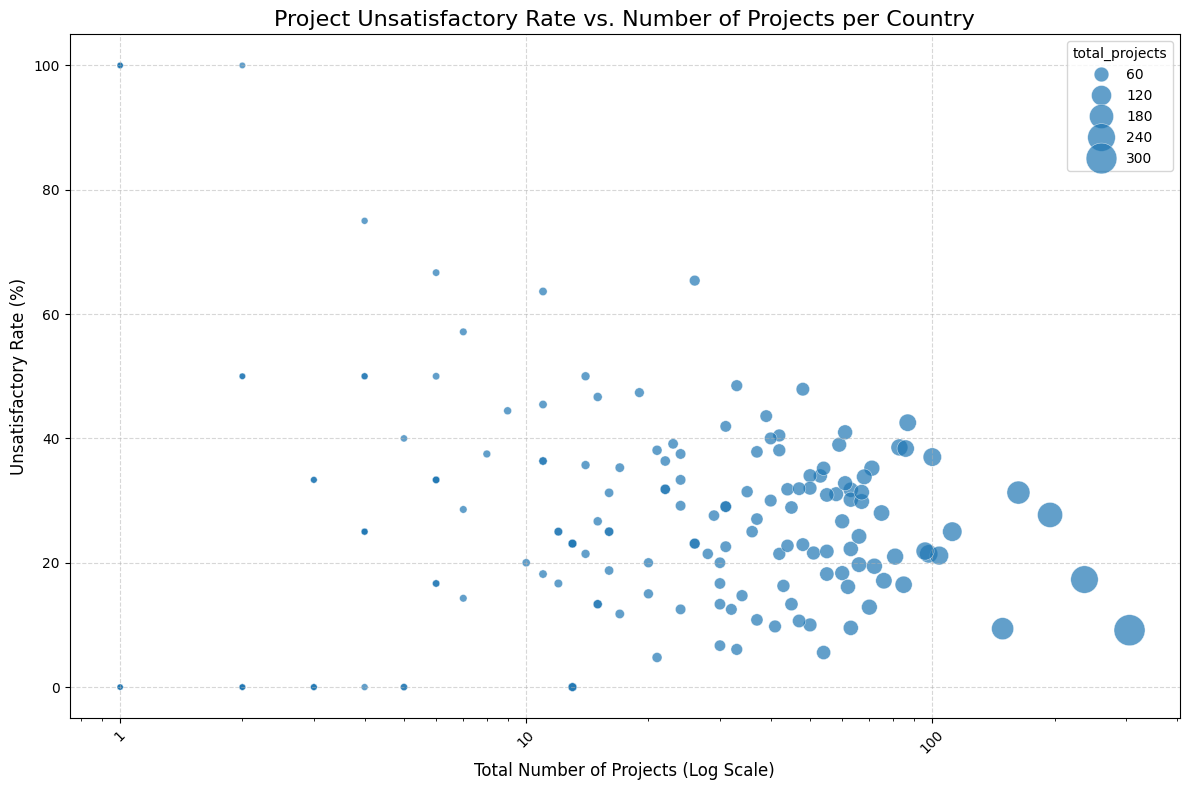


--- Scatter Plot Generation Complete ---


In [18]:
# --- 5. Create Scatter Plot ---
print("Generating scatter plot...")
plt.figure(figsize=(12, 8))

# Create scatter plot - Use log scale for x-axis (total_projects)
scatter_plot = sns.scatterplot(
    data=country_summary,
    x='total_projects',
    y='unsatisfactory_pct',
    size='total_projects',
    sizes=(20, 500),
    alpha=0.7
)

plt.xscale('log') # Use log scale for project count axis

# Add Titles and Labels
plt.title('Project Unsatisfactory Rate vs. Number of Projects per Country', fontsize=16)
plt.xlabel('Total Number of Projects (Log Scale)', fontsize=12)
plt.ylabel('Unsatisfactory Rate (%)', fontsize=12)

# Improve axis formatting
from matplotlib.ticker import ScalarFormatter
scatter_plot.xaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n--- Scatter Plot Generation Complete ---")


In [19]:
# --- 5. Sort and Select Top N ---
# Sort by unsatisfactory rate (highest first)
country_summary_sorted_rate = country_summary.sort_values('unsatisfactory_rate', ascending=False)

# Select Top N (e.g., N=25)
N = 25
top_n_countries = country_summary_sorted_rate.head(N)
print(f"\nSelected Top {N} countries by unsatisfactory rate.")



Selected Top 25 countries by unsatisfactory rate.


Generating bar chart...


<ipython-input-20-b0254b20cefe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


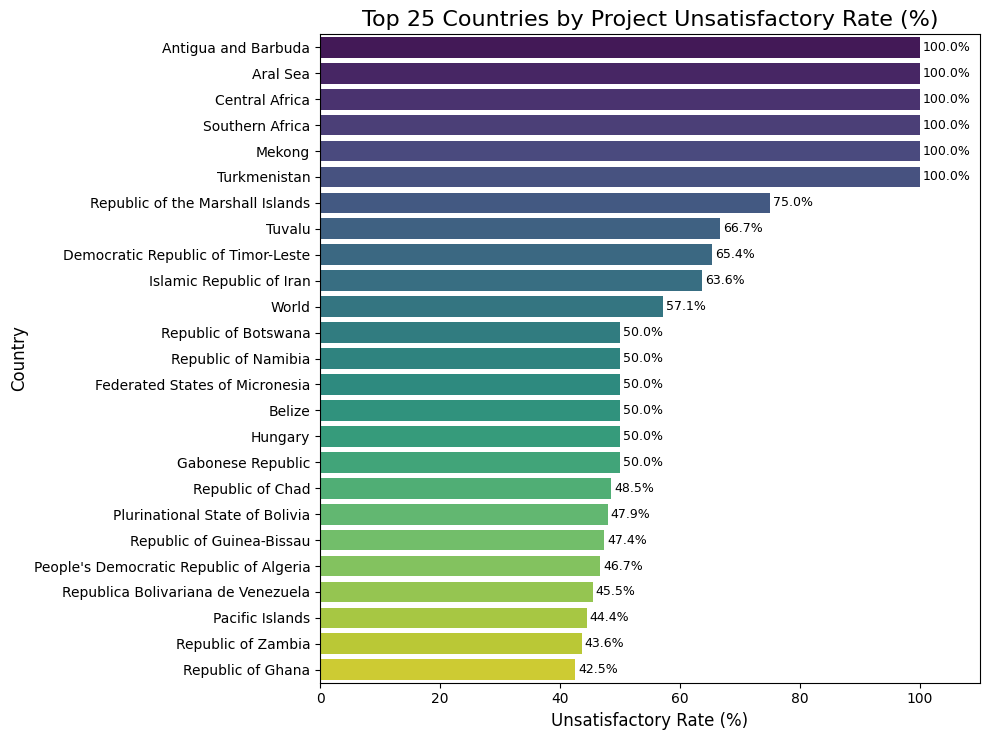


--- Bar Chart Generation Complete ---


In [20]:
# --- 6. Create Bar Chart ---
print("Generating bar chart...")
plt.figure(figsize=(10, N * 0.3)) # Adjust figure size based on N

# Create bar plot with countries on y-axis for readability
bar_plot = sns.barplot(
    data=top_n_countries,
    y=country_col,          # Countries on vertical axis
    x='unsatisfactory_pct', # Percentage on horizontal axis
    palette='viridis'       # Choose a color palette
)

# Add Titles and Labels
plt.title(f'Top {N} Countries by Project Unsatisfactory Rate (%)', fontsize=16)
plt.xlabel('Unsatisfactory Rate (%)', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Add percentage labels on bars (optional)
for index, value in enumerate(top_n_countries['unsatisfactory_pct']):
    plt.text(value + 0.5, index, f'{value:.1f}%', va='center', fontsize=9)

plt.xlim(0, max(105, top_n_countries['unsatisfactory_pct'].max() * 1.1)) # Ensure space for labels
plt.tight_layout()
plt.show()

print("\n--- Bar Chart Generation Complete ---")